In [1]:
# if not installed
# import sys
# sys.path.append("./..")

In [2]:
# To download the mnist dataset 
from torchvision import datasets

In [3]:
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
from embedml.tensor import Tensor
from embedml.nn import Linear
from embedml.nn import Module
from embedml.nn import LogSoftmax
from embedml.util import DataLoader
from embedml.util import Dataset
from embedml.nn import SGD
from embedml.nn import CrossEntropy

In [5]:
ds = datasets.MNIST('data', download=True)

In [6]:
class dataset(Dataset):
    def __init__(self, data, targets):
        super().__init__()
        self.len = len(data)
        self.data = data.view((-1, 28 * 28)).float()
        self.normalize()
        self.targets = targets

    def normalize(self):
        self.mean = self.data.mean(axis=-1, keepdim=True)
        self.std = self.data.std(axis=-1, keepdim=True)
        self.data = (self.data - self.mean) / self.std
        
    def __getitem__(self, idx):
        return Tensor(self.data[idx], requires_grad=False), Tensor(self.targets[idx], requires_grad=False)

    def __len__(self):
        return self.len

In [7]:
train_ds , test_ds = (ds.data[:50000], ds.targets[:50000]) , (ds.data[50000:], ds.targets[50000:])
train = dataset(*train_ds)

In [8]:
t_dl = DataLoader(train, batch_size=128, shuffle=True)

In [9]:
class simple(Module):
    def __init__(self):
        super().__init__()
        self.l1 = Linear(28 * 28, 64)
        self.l2 = Linear(64, 10)
        self.ac = LogSoftmax(dim=1)
    def forward(self, data):
        y0 = self.l1(data).relu()
        y1 = self.ac(self.l2(y0))
        return y1

In [10]:
m = simple()

In [11]:
p = m.get_parameters()
opt = SGD(p, Tensor(np.array(0.0005)))

In [12]:
target = np.array(test_ds[1])
test = Tensor(test_ds[0].reshape((-1, 784)), requires_grad=False)

In [13]:
criterion = CrossEntropy(num_class=10)

In [14]:
trace = {'loss':[], 'acc':[]}

In [ ]:
nepoch = 1
for i in range(nepoch):
    with tqdm(t_dl) as tq:
        for idx, (x, t) in enumerate(tq):
            y = m(x)
            loss = criterion(y, t)
            loss.backward()
            opt.step()
            opt.zero_grad()
            label = m(test).data.argmax(axis=-1)
            accuracy = (label == target).sum() * 100 / target.shape
            trace['loss'].append(loss.data[0][0])
            trace['acc'].append(accuracy)
            tq.set_postfix(accuracy=f'{trace["acc"][-1][0]:0.4f}')

Text(0, 0.5, 'Percent')

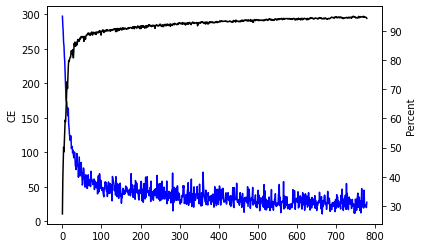

In [ ]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
l1, = ax1.plot(trace['loss'], color='blue', label='loss')
l2, = ax2.plot(trace['acc'], color='black', label='accuracy')

ax1.set_ylabel('CE')
ax2.set_ylabel('Percent')

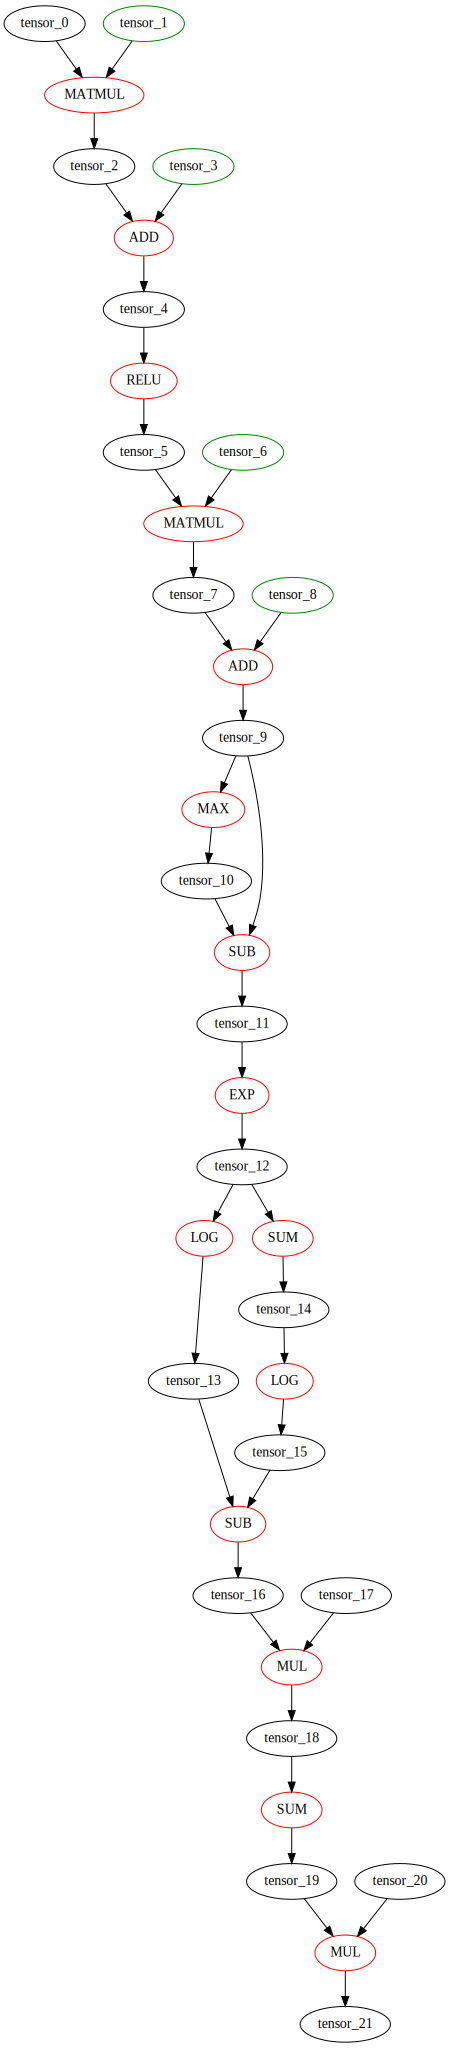

In [25]:
from embedml.util import draw
# x, t = next(t_dl)
# y = m(x)
# loss = criterion(y, t)
draw(loss)